In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)


('2017-08-23',)


In [11]:
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores

prcp = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(prcp, columns=['date','prcp'])
prcp_df.set_index('date').head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


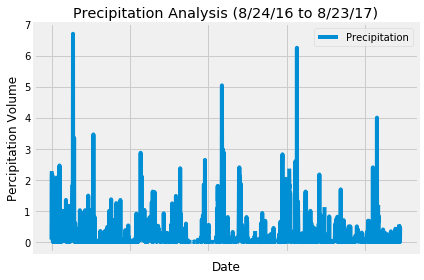

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot('date', 'prcp')
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Percipitation Volume")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
location_station = session.query(Measurement).group_by(Measurement.station).count()
print(location_station)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?

# List the stations and the counts in descending order.
weather_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

weather_stations

popular_station = weather_stations[0][0]    
popular_station

'USC00519281'

In [18]:
# List the stations and the counts in descending order.
for station, count in weather_stations:
    print("This station id:",station,"has this many weather observations:",count,)

This station id: USC00519281 has this many weather observations: 2772
This station id: USC00519397 has this many weather observations: 2724
This station id: USC00513117 has this many weather observations: 2709
This station id: USC00519523 has this many weather observations: 2669
This station id: USC00516128 has this many weather observations: 2612
This station id: USC00514830 has this many weather observations: 2202
This station id: USC00511918 has this many weather observations: 1979
This station id: USC00517948 has this many weather observations: 1372
This station id: USC00518838 has this many weather observations: 511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature_intel = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == popular_station).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()


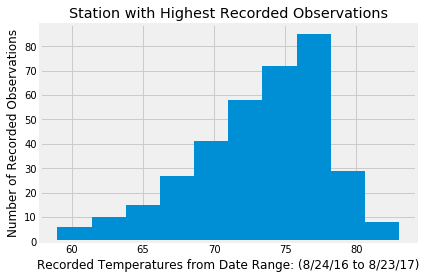

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.grid(True)
temp_intel_df = pd.DataFrame(temperature_intel)
plt.hist(temp_intel_df['tobs'])
bin_size = 12
plt.xlabel("Recorded Temperatures from Date Range: (8/24/16 to 8/23/17)")
plt.ylabel("Number of Recorded Observations")
plt.title("Station with Highest Recorded Observations")
plt.show()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
arrival_date = dt.date(2017, 1, 1)
departure_date = dt.date(2017, 1, 20)
one_year_ago = dt.timedelta(days=365)
tavg_year_ago = (calc_temps((arrival_date-one_year_ago), (departure_date-one_year_ago)))
print(tavg_year_ago)

[(61.0, 69.46610169491525, 78.0)]


C:\Users\Owner\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


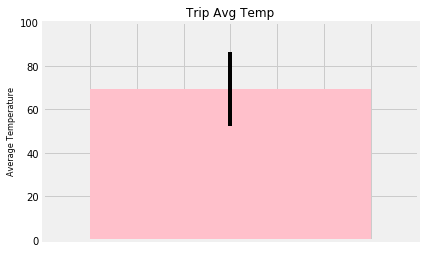

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
# Add  labels, title and axes ticks
ax.set_ylabel("Average Temperature", fontsize=8)
ax.set_title("Trip Avg Temp", fontsize=12)
y = [tavg_year_ago[0][1]]
x = 0
yerr_val = tavg_year_ago[0][2] - tavg_year_ago[0][0]
# Set the limits of the x and y axes, no tick params
ax.bar(x, y, width=1.5, color="pink", yerr=yerr_val)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 100)
ax.set_xbound(lower=-1, upper=1)
ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
plt.show()

In [24]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Rainfall_results = session.query(Measurement.station, func.count(Measurement.prcp)).\
                   group_by(Measurement.station).filter(Measurement.date.between('2016-08-01', '2017-08-01')).all()
Rainfall_results

[('USC00513117', 365),
 ('USC00514830', 261),
 ('USC00516128', 331),
 ('USC00517948', 67),
 ('USC00519281', 365),
 ('USC00519397', 361),
 ('USC00519523', 320)]

## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-07-01'
end_date ='2017-07-14'

# Use the start and end date to create a range of datesstart_month_day = trip_dates_stripped[0]
dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()

# Stip off the year and save a list of %m-%d strings
trip_dates = [x[0] for x in dates]
trip_dates_stripped= [x[5:] for x in trip_dates]

start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
daily_normals

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0)]

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])
daily_normals_df['date']= trip_dates
daily_normals_df.set_index('date',inplace=True)
daily_normals_df

,tmin,tavg,tmax
date,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0


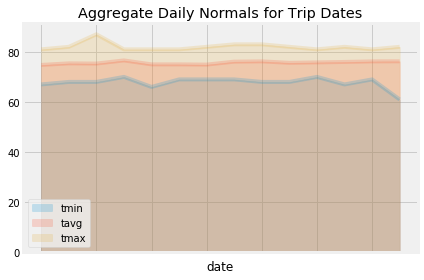

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()